In [129]:
# put the directory path to your LMR repository here
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
#sys.path.append("/Users/hakim/gitwork/LMR_python3")

In [130]:
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time

In [131]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline

In [74]:
def mk_pproxies(X,Xbp,prox_manager,SNR,grid):

    """
    Construct pseudoproxies 
    """

    numprox = len(prox_manager.ind_assim)

    vY = np.zeros([numprox,grid.nens])
    vR = []
    vP = []

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon

        # Noise amplitude corresponding to SNR by stdev
        sig = np.std(Xbp[npos,:])
        #print(sig)
        #print(sig/SNR)
        # Make pproxies
        vY[proxy_idx,:] = Xbp[npos,:] + np.random.randn(grid.nens,)*sig/SNR
        vR.append((sig/SNR)**2)
        vP.append(proxy_idx)

    return vY, vR, vP

def mk_yes(X,Xbp,prox_manager,grid):

    vYe = np.zeros([numprox,grid.nens])
    vYe_coords = np.zeros([numprox,2])

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon
        # the ensemble prior estimates
        vYe[proxy_idx,:] = Xbp[npos,:]
        vYe_coords[proxy_idx,:] = X.coords[npos,:]

    return vYe, vYe_coords


In [132]:
# prefix for figure filename
fig_prefix='nspace_LGM'

In [133]:
# use this when revising modules; this reloads
import importlib
importlib.reload(LMRlite)

<module 'LMR_lite_utils' from '/Users/dan/Desktop/LMR_py3/LMR_lite_utils.py'>

In [134]:
# check for user-specified config file; otherwise, use the one in the SRC directory

# this block is for the command line (.py version of this code)
#if len(sys.argv) > 1:
#    yaml_file = sys.argv[1]
#else:
#    yaml_file = os.path.join(LMR_config.SRC_DIR,'config_lite.yml')

# this block is for Jupyter:
#cfile = 'config_lite.yml.dadt'
cfile = 'config.yml.nullspace_lgm'

yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)

cfg = LMRlite.load_config(yaml_file)

Checking configuration ... 
OK!


In [21]:
# load proxies
prox_manager = LMRlite.load_proxies(cfg)

                        Marine sediments_uk37 :   101
                                        TOTAL :   101
-----------------------------------------------------
completed in 56.931751012802124 seconds
-----------------------------------------------------


In [135]:
# load prior
X, Xb_one = LMRlite.load_prior(cfg)
Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)

Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm3_trace21ka/tas_sfc_Adec_CCSM3_TraCE21ka.nc
:: Data temporal resolution =  10.0 yrs
Array dims : ('time', 'lat', 'lon')
Array shape: (2204, 48, 96)
Type of variable: 2D:horizontal
indlat(orig)= 1  indlon(orig)= 2
indlat      = 0  indlon      = 1
Full field provided as the prior
tas : Global: mean= 272.15344  , std-dev= 22.453375
Averaging period (years): 200
tas : Global(time-averaged): mean= 272.14795  , std-dev= 22.453724
 
State vector information:
Nx = 4608
state_vect_info= {'tas_sfc_Adec': {'pos': (0, 4607), 'spacecoords': ('lat', 'lon'), 'spacedims': (48, 96), 'vartype': '2D:horizontal', 'units': 'K'}}
Random selection of 75 ensemble members


In [15]:
# print some information about the prior
print(X.trunc_state_info)
var = list(X.statevars.keys())[0]
print(list(X.prior_dict[var].keys()))
print(X.prior_dict[var]['lat'].shape)
print(X.prior_dict[var]['lon'].shape)

{'tas_sfc_Adec': {'pos': (0, 4607), 'spacecoords': ('lat', 'lon'), 'spacedims': (48, 96), 'vartype': '2D:horizontal', 'units': 'K'}}
['vartype', 'years', 'value', 'climo', 'units', 'spacecoords', 'lat', 'lon']
(48, 96)
(48, 96)


In [16]:
# check if config is set to regrid the prior
if cfg.prior.regrid_method:
    print('regridding prior...')
    # this function over-writes X, even if return is given a different name
    [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=True)
else:
    X.trunc_state_info = X.full_state_info
    
Xb_one = Xb_one_new
Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
grid = LMRlite.Grid(X)

regridding prior...
tas_sfc_Adec  : 2D lat/lon variable, truncating this variable
=> Full array:      206.0719451904297 300.7749938964844 272.23253937301814 22.38401235078546
=> Truncated array: 206.27301443045636 300.34712174509843 271.84883401553634 22.559383386014236


In [17]:
#print(dir(X.coords))
stateVectDim, nbdimcoord = X.coords.shape
print(stateVectDim, nbdimcoord)
X_lon = X.coords[:,1]
X_lat = X.coords[:,0]
print(X_lat.shape)
print(X_lon.shape)

# insure that Xbp still has zero mean
Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
print('check on zero mean prior...',np.max(np.mean(Xbp,1)))
print(Xbp.shape)

16380 2
(16380,)
(16380,)
check on zero mean prior... 1.356662930144618e-13
(16380, 75)


In [33]:
# load pre-calculated proxy estimates from the prior (Hx^p)
Ye_assim, Ye_assim_coords = LMR_utils.load_precalculated_ye_vals_psm_per_proxy(cfg, prox_manager,'assim',X.prior_sample_indices)

INFO  : Loading Ye file:ccsm3_trace21ka-tos_sfc_Odecmon-full_bayesreg_uk37_200yrs-_NCDCdadtv0.1.1.npz
INFO  : Now extracting proxy type-dependent Ye values...
INFO  : Completed in 0.14747977256774902secs


In [34]:
#
# specify a localized function for the truth state, and then test its recovery
#

# center point for the function max
site_lat = 40.
site_lon = 330.
X_lat = X.prior_dict[var]['lat']
X_lon = X.prior_dict[var]['lon']
# distance from the max
dists = np.array(LMR_utils.haversine(site_lon, site_lat,X_lon,X_lat),dtype=np.float64)

# specify a decay length scale
locRad = 10000.

# gaussian
gauss = np.exp(-(dists/(locRad/2))**2)

# gaspari-cohn
"""
               hlr = 0.5*locRad; # work with half the localization radius
gauss = np.zeros(dists.shape)
for m in range(dists.shape[0]):
    for n in range(dists.shape[1]):
        dist = dists[m,n]
        r = dist/hlr
        if dist <=hlr:
            covLoc = (((-0.25*r+0.5)*r + 0.625)*r-(5.0/3.0))*(r**2)+1.0
        elif (dist > hlr) & (dist < 2.*hlr):
            covLoc = ((((r/12.-0.5)*r + 0.625)*r + 5.0/3.0)*r - 5.0)*r + 4.0 - 2.0/(3.0*r)                    
        elif dist >= 2*hlr:
            covLoc = 0.
            
        gauss[m,n] = covLoc"""

'\n               hlr = 0.5*locRad; # work with half the localization radius\ngauss = np.zeros(dists.shape)\nfor m in range(dists.shape[0]):\n    for n in range(dists.shape[1]):\n        dist = dists[m,n]\n        r = dist/hlr\n        if dist <=hlr:\n            covLoc = (((-0.25*r+0.5)*r + 0.625)*r-(5.0/3.0))*(r**2)+1.0\n        elif (dist > hlr) & (dist < 2.*hlr):\n            covLoc = ((((r/12.-0.5)*r + 0.625)*r + 5.0/3.0)*r - 5.0)*r + 4.0 - 2.0/(3.0*r)                    \n        elif dist >= 2*hlr:\n            covLoc = 0.\n            \n        gauss[m,n] = covLoc'

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


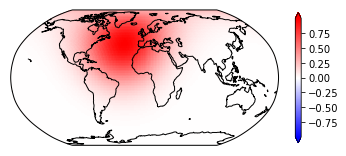

In [64]:
LMRlite.make_plot(gauss,grid,figsize=6)

In [66]:
# draw new "pseudoproxies" from the known field (hacked from LMR_lite_utils)
#
# this block draws observations from locations of the proxies specified in the config file
#
# vY are ob values
# vR are the ob errors
#

nlat = grid.nlat
nlon = grid.nlon

vY = []
vR = []
vP = []
vYe = np.zeros(Ye_assim.shape)
vYe_coords = np.zeros([Ye_assim.shape[0],2])

for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
    #print(Y.lat,Y.lon)
    # get grid indices
    tmp = grid.lat[:,0]-Y.lat
    itlat = np.argmin(np.abs(tmp))
    tmp = grid.lon[0,:]-Y.lon
    itlon = np.argmin(np.abs(tmp))
    # check that we have the correct point
    #print(itlat,itlon)
    #print('orig:',"%4.1f"%Y.lat,Y.lon)
    #print('check:'"%4.1f"%grid.lat[itlat,0],grid.lon[0,itlon])    
    # the observations
    vY.append(gauss[itlat,itlon])
    vR.append(0.001)
    vP.append(proxy_idx)
    # the ensemble prior estimates
    npos = itlat*nlon + itlon
    vYe[proxy_idx,:] = Xbp[npos,:]
    vYe_coords[proxy_idx,:] = X.coords[npos,:]

print(vYe.shape)
print(vYe_coords.shape)
print(len(vY))
print(len(vP))

(101, 75)
(101, 2)
101
101


In [ ]:
#
# alternative option for pseudoproxies at every grid point
#

"""
vYe = np.copy(Xbp)
vYe_coords = np.copy(X.coords)
ndof = Xbp.shape[0]
vY = np.squeeze(np.reshape(gauss,(ndof,1)))
vR = np.squeeze(.001*np.ones([ndof,1]))
# this one can only be practically solved on a laptop with the optimal
#xam,Xap,_ = LMRlite.Kalman_optimal(vY,vR,vYe,Xbp,verbose=True)
"""

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


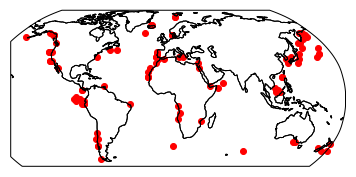

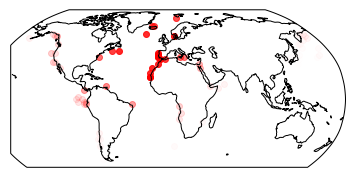

In [74]:
# check that proxy values are correct; first all locations, then alpha shaded by value
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-0.))
ax.coastlines()
ax.scatter(vYe_coords[:,1],vYe_coords[:,0],c='r',alpha=1,transform=ccrs.PlateCarree())
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-0.))
ax.coastlines()
plt.savefig(fig_prefix+'proxy_network.png',dpi=300)

plt.show()
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-0.))
ax.coastlines()

for k in range(len(vY)):
    ax.scatter(vYe_coords[k,1],vYe_coords[k,0],c='r',alpha=vY[k],transform=ccrs.PlateCarree())

plt.savefig(fig_prefix+'proxy_network_values.png',dpi=300)


In [91]:
# option to change the localization radius in the config file (used by DA code)
print(cfg.core.loc_rad)
cfg_params = LMR_utils.param_cfg_update('core.loc_rad',5000.)
cfg_new = LMR_config.Config(**cfg_params)

print(cfg_new.core.loc_rad)

25000
5000.0


In [92]:
# DA with the pseudoproxies
import importlib
importlib.reload(LMRlite)

xam,Xap,_ = LMRlite.Kalman_optimal(vY,vR,vYe,Xbp,verbose=True)
xam2,Xap2 = LMRlite.Kalman_ESRF(cfg_new,vY,vR,vYe,Xbp,X=X,vYe_coords=vYe_coords,verbose=True)



 all-at-once solve...

number of obs: 101
number of ensemble members: 75
ndof :75
U :(101, 101)
s :(75,)
V :(75, 75)
recontructing using 74 singular values
min s: 1.5270505207294105e-13
shape of U: (101, 101)
shape of s: (75,)
shape of V: (75, 75)
-----------------------------------------------------
completed in 0.014626741409301758 seconds
-----------------------------------------------------
Ensemble square root filter...
Xb shape: (16481, 75)
X coords shape (16380, 2)
X aug coords shape (16481, 2)
appended state...


/Users/dan/Desktop/LMR_py3/LMR_DA.py:157: RuntimeWarning: invalid value encountered in less_equal
  ind_inner = np.where(dists <= hlr)    # closest
/Users/dan/Desktop/LMR_py3/LMR_DA.py:158: RuntimeWarning: invalid value encountered in greater
  ind_outer = np.where(dists >  hlr)    # close
/Users/dan/Desktop/LMR_py3/LMR_DA.py:159: RuntimeWarning: invalid value encountered in greater
  ind_out   = np.where(dists >  2.*hlr) # out
/Users/dan/Desktop/LMR_py3/LMR_utils.py:89: RuntimeWarning: invalid value encountered in arcsin
  c = 2 * np.arcsin(np.sqrt(a))


-----------------------------------------------------
completed in 0.8675410747528076 seconds
-----------------------------------------------------


In [93]:
# ensemble variance in prior and posterior
xavar = np.var(Xap2,axis=1,ddof=1)
xbvar = np.var(Xbp,axis=1,ddof=1)

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


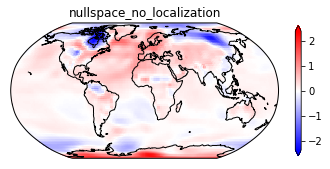

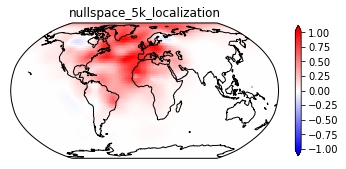

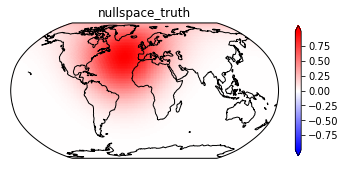

In [94]:
# no localization
xam_lalo = np.reshape(xam,[grid.nlat,grid.nlon])
LMRlite.make_plot(xam_lalo,grid,figsize=6,savefig=fig_prefix+'no_localization')
# localization
xam_lalo2 = np.reshape(xam2,[grid.nlat,grid.nlon])
LMRlite.make_plot(xam_lalo2,grid,figsize=6,savefig=fig_prefix+'5k_localization')
# truth
LMRlite.make_plot(gauss,grid,figsize=6,savefig=fig_prefix+'truth')

#xam_lalo2 = np.reshape(xa2var,[grid.nlat,grid.nlon])
#LMRlite.make_plot(xam_lalo2,grid,figsize=6)
#xam_lalo3 = np.reshape(xbvar,[grid.nlat,grid.nlon])
#LMRlite.make_plot(xam_lalo3-xam_lalo2,grid,figsize=6)